In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tqdm as notebook_tqdm

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


### Load and Preprocess data

✓ Total examples: 318

✓ Available keys: dict_keys(['image', 'caption', 'sentids', 'img_id', 'filename'])


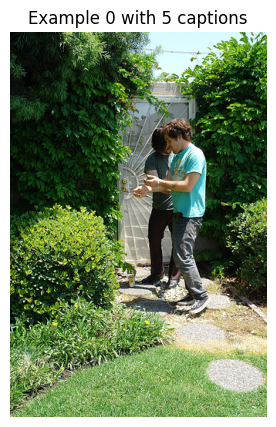


--- Example 0 Captions ---
1. Two young guys with shaggy hair look at their hands while hanging out in the yard .
2. Two young  White males are outside near many bushes .
3. Two men in green shirts are standing in a yard .
4. A man in a blue shirt standing in a garden .
5. Two friends enjoy time spent together .


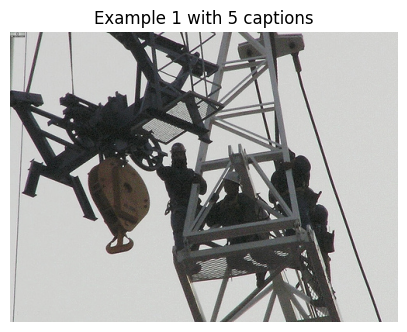


--- Example 1 Captions ---
1. Several men in hard hats are operating a giant pulley system .
2. Workers look down from up above on a piece of equipment .
3. Two men working on a machine wearing hard hats .
4. Four men on top of a tall structure .
5. Three men on a large rig .


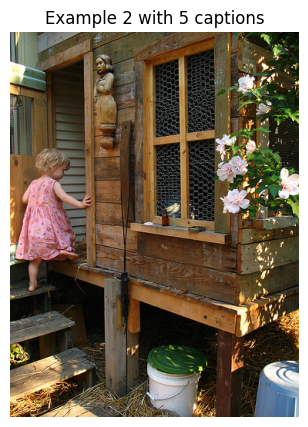


--- Example 2 Captions ---
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A little girl in a pink dress going into a wooden cabin .
3. A little girl climbing the stairs to her playhouse .
4. A little girl climbing into a wooden playhouse 
5. A girl going into a wooden building .


In [4]:
try:
    dataset = load_dataset("lmms-lab/flickr30k", split="test[:1%]")
    
    print(f"✓ Total examples: {len(dataset)}")
    
    example = dataset[0]
    print(f"\n✓ Available keys: {example.keys()}")
    
    # Show first 3 image-caption
    for i in range(3):
        ex = dataset[i]
        image = ex["image"]
        captions = ex.get("caption", ex.get("captions", []))
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Example {i} with {len(captions)} captions", fontsize=12)
        plt.show()

        print(f"\n--- Example {i} Captions ---")
        if isinstance(captions, list):
            for j, c in enumerate(captions):
                print(f"{j+1}. {c}")
        else:
            print(captions)
        
except Exception as e:
    print(f"Error: {e}")
    print("\nTry alternative approach...")

In [13]:
print(dataset)

Dataset({
    features: ['image', 'caption', 'sentids', 'img_id', 'filename', 'pixel_values'],
    num_rows: 318
})


In [14]:
def clean_caption(caption):
    caption = caption.lower().strip()
    caption = re.sub(r'[^a-z0-9\s.,!?-]', '', caption)
    return ' '.join(caption.split())

In [15]:
pairs = []
for example in dataset:
    image = example["image"]
    if image.mode != 'RGB':
        image = image.convert('RGB')
    for caption in example["caption"]:
        cleaned = clean_caption(caption)
        if 5 <= len(cleaned.split()) <= 50:
            pairs.append({'image': image, 'caption': cleaned})

In [16]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}")

Train: 1268, Val: 318


### Create dataset

In [17]:
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class ImageCaptionDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image = self.transform(pair['image']) if self.transform else pair['image']
        return {'image': image, 'caption': pair['caption']}

In [18]:
train_dataset = ImageCaptionDataset(train_pairs, image_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Load CLIP

In [28]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

### Text -> Embedding function

In [29]:
def get_text_embeddings(captions):
    tokens = tokenizer(captions, padding="max_length", max_length=77, 
                      truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(device))[0]
    return embeddings

### Pipeline test

In [31]:
batch = next(iter(train_loader))
embeddings = get_text_embeddings(batch['caption'])

print(f"\n✅ BASELINE PIPELINE COMPLETE!")
print(f"Images: {batch['image'].shape}")
print(f"Text embeddings: {embeddings.shape}")
print(f"Sample caption: {batch['caption'][0]}")


✅ BASELINE PIPELINE COMPLETE!
Images: torch.Size([16, 3, 256, 256])
Text embeddings: torch.Size([16, 77, 512])
Sample caption: three guys riding on an elephant with a house like structures and trees in the background .


### Visualize

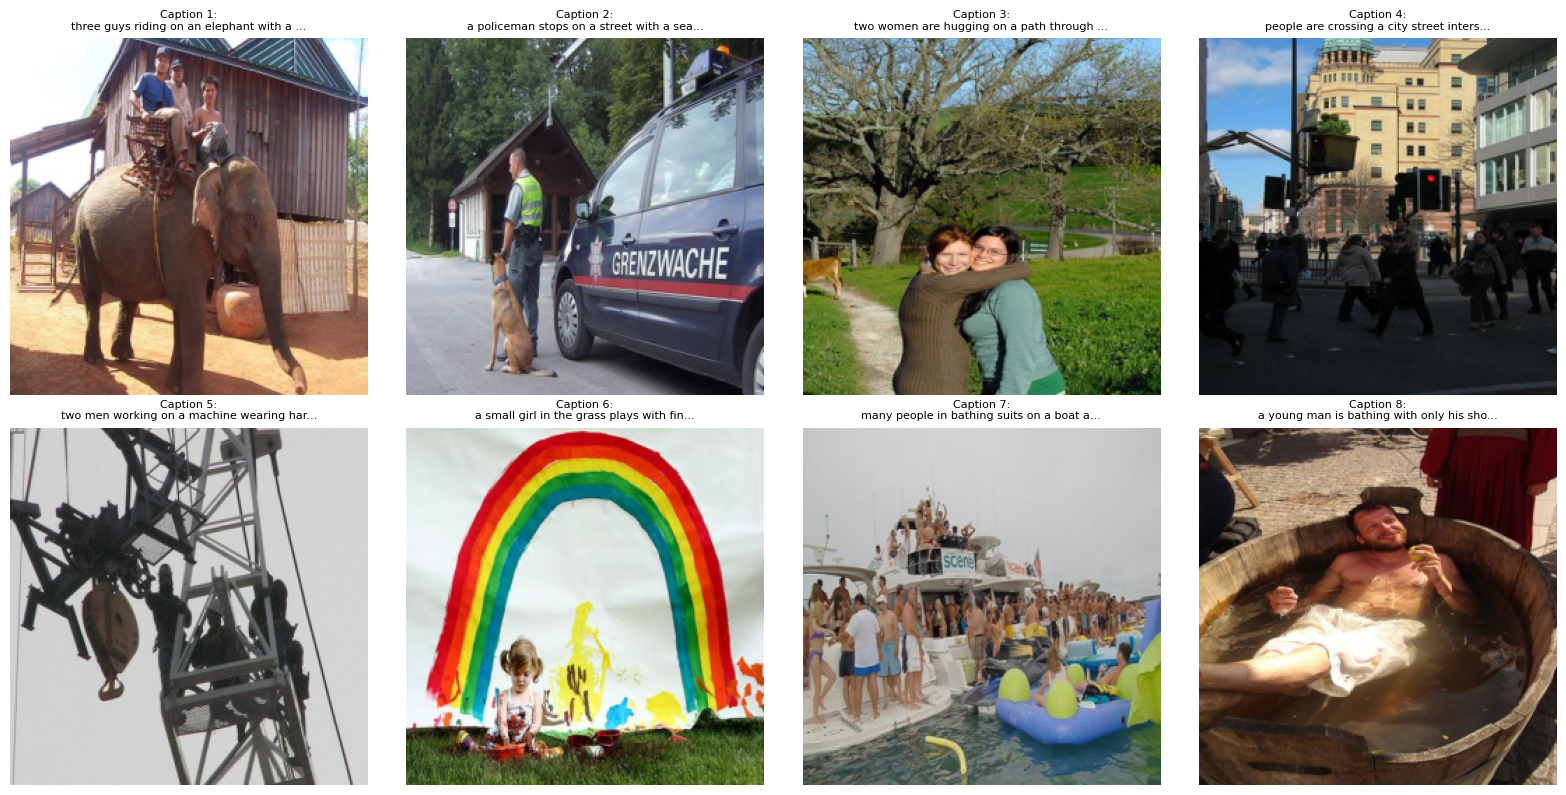


All steps complete! Ready for model training.


In [34]:
def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    axes[0, i].imshow(denormalize(batch['image'][i]))
    axes[0, i].set_title(f"Caption {i+1}:\n{batch['caption'][i][:40]}...", fontsize=8)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(denormalize(batch['image'][i+4]))
    axes[1, i].set_title(f"Caption {i+5}:\n{batch['caption'][i+4][:40]}...", fontsize=8)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

print("\nAll steps complete! Ready for model training.")